In [1]:
%matplotlib inline
from __future__ import division
from copy import deepcopy
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import random as py_random
import seaborn as sns
import scipy.stats as stats
import sklearn.neighbors as neighbors
import sklearn.linear_model as linear
import sklearn.metrics.pairwise as pairwise
import time

from IPython.display import display, HTML

sns.set(style="darkgrid")

# Define the random seed we'll use
SEED = 123454321
def set_seed():
    np.random.seed(SEED)
    py_random.seed(SEED)
    
    
# [1]
# Error rate ((FN + FP) / n)
def error_rate(errors):
    # 1 means False Negative (y=1, y_hat=0, y-y_hat = 1)
    # -1 means False Positive (y=0, y_hat=1,  y-y_hat = -1)
    errors = np.abs(errors)
    return np.sum(errors) / len(errors)

# Module 10 Lab - Distance Based Machine Learning

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

We're getting to the point in the semester where you should be know the drill. Our goal is to understand our tools very well by generating data we think the tool would work with and data we think wouldn't work.

This module covered 3 basic problems: supervised learning (classification, regression), unsupervised learning (clustering) and recommenders (collaborative filtering based systems related to missing value imputation) using distance/similarity. We're only going to cover the first 2 in this lab.

You should definitely use [Scikit Learn](http://scikit-learn.org/stable/) and refer to the documentation for this assignment.

Remember to create a new random seed for each experiment and save it.

**Problem 1. Classification**

Use k-Nearest Neighbors for a classification problems of your own creation (you can use data from previous labs that had classification problems as a start). You should explore the following points:

1. Is the boundary between the classes very distinct or fuzzy? What if it's a mixture (distinct for some variable and fuzzy for another)?
2. What happens if you vary the "shape" of the classes? (Not just perfect circles but interlocking "moons" or other shapes).
3. How do you pick a value for k?
4. Compare with logistic regression.

**P1: Q1a**: _Is the boundary between the classes very distinct or fuzzy?_

For this classification problem we'll use a training data set having a single underlying classification of (1,2,3) where:
- if class=1:  $X_1 = N(2,1) , X_2=N(2,1)$
- if class=2:  $X_1 = N(5,1) , X_2=N(5,1)$
- if class=3:  $X_1 = N(8,1) , X_2=N(8,1)$

The first plot will show the results that a trained K Nearest Neighbor classifier would predict with K=11 for a range of possible X1,X2 values overlayed with the actual training data:

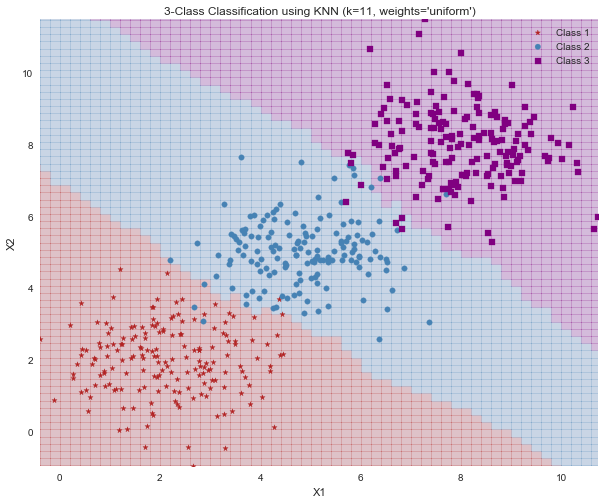

In [2]:
# [2] 
def p1_q1a_data(size=500, stddev=1):
    set_seed()
    # Generate samples for 3 hidden classes of data
    classes = np.random.randint(low=1, high=4, size=size)
    x1s = []
    x2s = []
    ys = []
    for cl in classes:
        if cl == 1:
            ys.append(1)
            x1s.append(np.random.normal(loc=2, scale=stddev, size=1))
            x2s.append(np.random.normal(loc=2, scale=stddev, size=1))
        if cl == 2:
            ys.append(2)
            x1s.append(np.random.normal(loc=5, scale=stddev, size=1))
            x2s.append(np.random.normal(loc=5, scale=stddev, size=1))
        if cl == 3:
            ys.append(3)
            x1s.append(np.random.normal(loc=8, scale=stddev, size=1))
            x2s.append(np.random.normal(loc=8, scale=stddev, size=1))
    
    df = pd.DataFrame.from_records(data=zip(ys,x1s,x2s), columns=['Y','X1','X2'])
    return df


# Train a KNN Classifier
def knn_classify(data, k=11, weights='uniform'):    
    results = {}
    results['k'] = k
    results['weights'] = weights
    results['data'] = data
    
    clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights=weights)
    clf.fit(data[['X1','X2']], data.Y)
    results['clf'] = clf
    return results

# [2]
def plot_KNN_classifiction(results):
    clf = results['clf']
    data = results['data']
    
    # Generate a set of predictions to use in creating a plot
    # Predict a class for all points in the graph
    x1s = np.arange(np.min(data.X1) -1, np.max(data.X1) + 1, .2)
    x2s = np.arange(np.min(data.X2) -1, np.max(data.X2) + 1, .2)
    xx, yy = np.meshgrid(x1s, x2s)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the classification space based on the predictions
    figure = plt.figure(figsize=(10,8))
    axes = figure.add_subplot(1,1,1)

    # Use a color mesh plot to show the classifications prediction will return
    # based on X1, X2
    cmap_light = ListedColormap(['firebrick','steelblue','purple'])
    axes.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=.2)

    # Plot training data by classification
    dc = data[data.Y == 1]
    axes.scatter(dc.X1, dc.X2, s=30, color='firebrick', marker='*', alpha=1, label='Class 1')
    dc = data[data.Y == 2]
    axes.scatter(dc.X1, dc.X2, s=30, color='steelblue', marker='o', alpha=1, label='Class 2')
    dc = data[data.Y == 3]
    axes.scatter(dc.X1, dc.X2, s=30, color='purple', marker='s', alpha=1, label='Class 3')

    # Plot labels & boundaries
    axes.set_title("3-Class Classification using KNN (k={0}, weights='{1}')".format(results['k'], results['weights']))
    axes.set_xlabel("X1")
    axes.set_ylabel("X2")
    axes.set_xlim(np.min(data.X1), np.max(data.X1))
    axes.set_ylim(np.min(data.X2), np.max(data.X2))
    axes.legend()
    plt.show()

    
# First experiment.  Minimal overlap
results = knn_classify(data=p1_q1a_data())
plot_KNN_classifiction(results)

**Observations**:
The boundaries between classifications are reasonably solid and distinct in this expirement. This is a reflection of the fact that the training data was generated using 3 separate normal distributions, each having a $\mu$ that was roughly 2+ $\sigma$ distant from any of the other distributions, resulting in minimal overlap between the classes. 

**P1: Q1b**: _What if it's a mixture (distinct for some variable and fuzzy for another)?_

What happens then if we blend 2 of the classes together?   Lets try shifting the 2nd and 3rd classes so that there is an increased overlap:
- if class 1:  $X_1 = N(2,1), X_2 = N(2,1)$
- if class 2:  $X_1 = N(6,1), X_2 = N(6,1)$
- if class 3:  $X_1 = N(8,1), X_2 = N(6,1)$

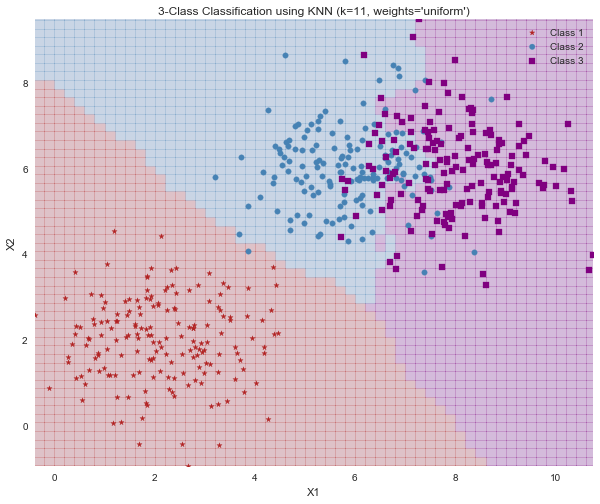

In [3]:
def data_p1q1b():
    set_seed()
    classes = np.random.randint(low=1, high=4, size=500)
    x1s = []
    x2s = []
    ys = []
    for cl in classes:
        ys.append(cl)
        if cl == 1:
            x1s.append(np.random.normal(loc=2, scale=1))
            x2s.append(np.random.normal(loc=2, scale=1))
        if cl == 2:
            x1s.append(np.random.normal(loc=6, scale=1))
            x2s.append(np.random.normal(loc=6, scale=1))
        if cl == 3:
            x1s.append(np.random.normal(loc=8, scale=1))
            x2s.append(np.random.normal(loc=6, scale=1))
            
    return pd.DataFrame.from_records(data=zip(ys,x1s,x2s), columns=['Y','X1','X2'])

results = knn_classify(data=data_p1q1b())
plot_KNN_classifiction(results)

**Observations**:
The classification boundary between classes 2 and 3 has become much fuzzier thanks to considerable overlap between between those classes.  The boundary is now jagged, with several training points for Class 2 showing up in the general space predicted as Class 3 and vice versa.  

**P1: Q2**: _What happens if you vary the "shape" of the classes? (Not just perfect circles but interlocking "moons" or other shapes)._

Lets see how the classification pans out if all 3 classes have some signficant overlap and position a bit differently in the chart:
- if class 1:  $X_1 = N(3,1), X_2 = N(3,1)$
- if class 2:  $X_1 = N(5,1), X_2 = N(5,1)$
- if class 3:  $X_1 = N(7,1), X_2 = N(3,1)$

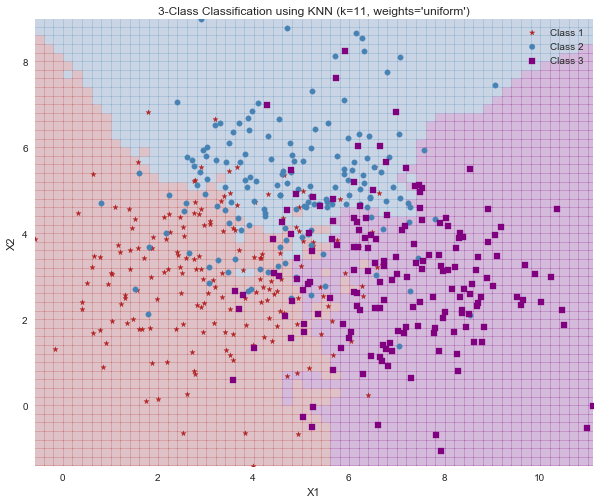

In [4]:
def p1_q2a_data():
    set_seed()
    classes = np.random.randint(low=1, high=4, size=500)
    x1s = []
    x2s = []
    ys = []
    for cl in classes:
        ys.append(cl)
        if cl == 1:
            x1s.append(np.random.normal(loc=3, scale=1.5))
            x2s.append(np.random.normal(loc=3, scale=1.5))
        if cl == 2:
            x1s.append(np.random.normal(loc=5, scale=1.5))
            x2s.append(np.random.normal(loc=5, scale=1.5))
        if cl == 3:
            x1s.append(np.random.normal(loc=7, scale=1.5))
            x2s.append(np.random.normal(loc=3, scale=1.5))
    return pd.DataFrame.from_records(data=zip(ys,x1s,x2s), columns=['Y','X1','X2'])

results = knn_classify(data=p1_q2a_data())
plot_KNN_classifiction(results)

**Observations**:

We have a lot more overlap between all 3 classes, which is causing the boundaries to blur considerably. In fact, just inside those boundaries you can see intermittent patches of the other/opposite classification present, showing just how much impact the overlap is having.

What if we use a different shape for class 3?
- if class 1:  $X_1 = N(3,1), X_2 = N(3,1)$
- if class 2:  $X_1 = N(5,1), X_2 = N(5,1)$
- if class 3:  $X_1$ is drawn from the Uniform distribution [4,10] and $X_2 = X_1 + \epsilon$, where $\epsilon=N(0,1)$

Class 3 will act more like a line cutting into class 2.

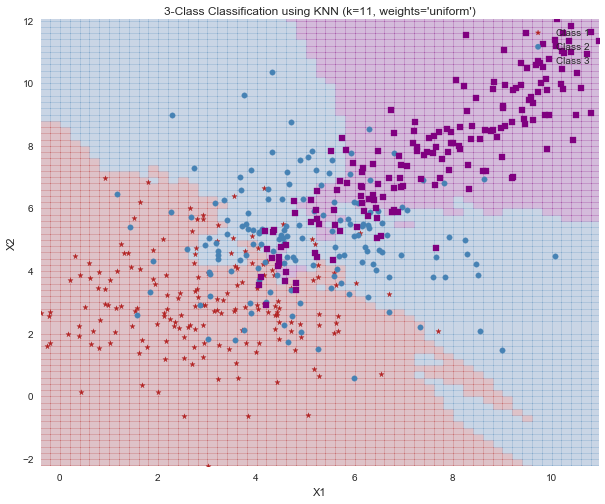

In [5]:
def p1_q2b_data():
    set_seed()
    classes = np.random.randint(low=1, high=4, size=500)
    x1s = []
    x2s = []
    ys = []
    for cl in classes:
        ys.append(cl)
        if cl == 1:
            x1s.append(np.random.normal(loc=3, scale=1.5))
            x2s.append(np.random.normal(loc=3, scale=1.5))
        if cl == 2:
            x1s.append(np.random.normal(loc=5, scale=1.5))
            x2s.append(np.random.normal(loc=5, scale=1.5))
        if cl == 3:
            x1 = np.random.uniform(low=4,high=11)
            e = np.random.standard_normal()
            x2 = x1 + e
            x1s.append(x1)
            x2s.append(x2)
    
    return pd.DataFrame.from_records(data=zip(ys,x1s,x2s), columns=['Y','X1','X2'])

results = knn_classify(data=p1_q2b_data())
plot_KNN_classifiction(results)

**Observations**:

As expected, class 3 is making the boundaries very interesting _and_ fuzzy. The space for classification 2 has been almost bisected by classification 3, resulting in 2 distinct regions for classification 2.  If there were more data points for classification 3's X1 in the [4,6] range we would see an even stronger separation. Classification 1 is left relatively unperturbed as there is minimal overlap there.   

**P1: Q3**: _How do you pick a value for k?_

We chose $k$ arbitrarily as 11 above based on inference from Module 10 lecture materials.  We know that $k$ should be odd to support a _majority vote_ when assigning a point to a classification based on the classification of the $k$ points sampled around it. There are more concise ways to pick $k$, specifically:
- the "_nearest neighbor_", that is... $k = 1$
- validation curves

Lets look at the effect of _nearest neighbor (k=1)_ applied to our original data set, then what happens as we increase $k$:

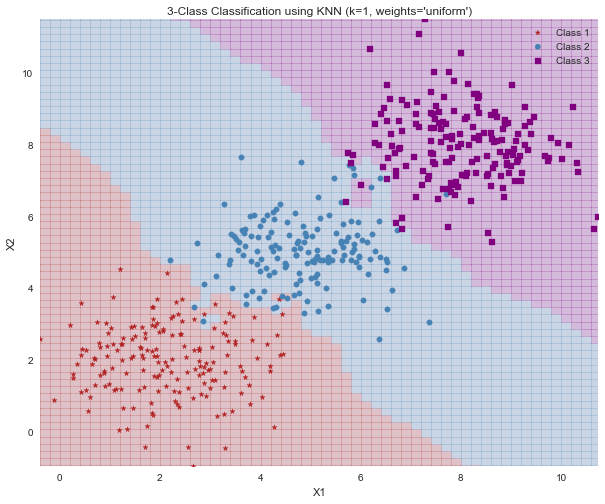

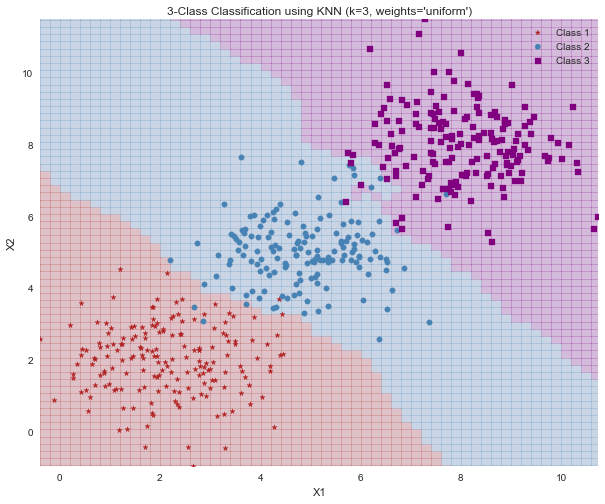

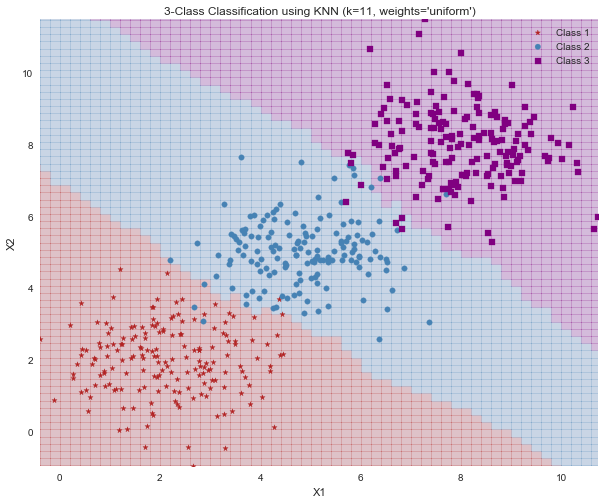

In [6]:
data = p1_q1a_data()

# k = 1
results = knn_classify(data, k=1)
plot_KNN_classifiction(results)

# k = 3
results2 = knn_classify(data, k=3)
plot_KNN_classifiction(results2)

# k = 5
results = knn_classify(data, k=11)
plot_KNN_classifiction(results)

**Observations**:
The impact of increasing the value of $k$ is obvious at the classification boundaries.  $k=1$ shows areas where class 2 bleeds into class 1,  and class 3 bleeding into class 2. At $k=3$ class 1 has a clear, solidified boundary and we have a minimal about of class 2 bleeding into class 3.  Finally, at $k=5$ we have a firmer boundary between classifications.  The effect of increasing $k$ is that noise is minimized, though it may be at the cost of accuracy when predicting classification in fine grained, tightly concentrated areas of 1 class or another.

Lets try applying _Validation Curves_ to find our best _k_:

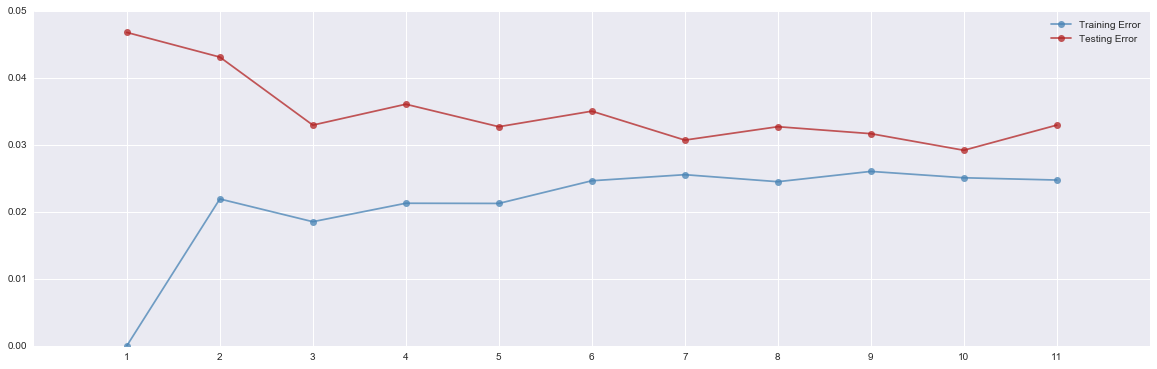

In [7]:
def cross_validate_knn(data, k=11, weights='uniform', folds=10):
    # Randomize the data
    indices = deepcopy(data.index).values
    np.random.shuffle(indices)
    rand_data = data.ix[indices]
    
    # Create the folds
    folds = np.array_split(rand_data, folds)
    
    training_error_rates = []
    testing_error_rates = []
    for i in xrange(len(folds)):
        # Train the model
        tr_folds = [folds[j] for j in xrange(len(folds)) if j != i]
        tr_data = pd.concat(tr_folds)
        clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights=weights)
        clf.fit(tr_data[['X1','X2']], tr_data.Y)
        
        # Calculate training error
        Y = tr_data.Y
        Y_hat = clf.predict(tr_data[['X1','X2']])
        Y_hat = np.ravel(Y_hat)
        errors = [1 if y != y_hat else 0 for y,y_hat in zip(Y,Y_hat)]
        training_error_rates.append(error_rate(errors))
        
        # Test the model
        te_data = folds[i]
        Y = te_data.Y
        Y_hat = clf.predict(te_data[['X1','X2']])
        Y_hat = np.ravel(Y_hat)
        errors = [1 if y != y_hat else 0 for y,y_hat in zip(Y,Y_hat)]
        testing_error_rates.append(error_rate(errors))
        
    return training_error_rates, testing_error_rates
        

def validation_curve_KNN(data, max_k=11, weights='uniform', iterations=10):    
    training_error_rates = []
    testing_error_rates = []
    ks = np.arange(1, max_k + 1, 1)
    for k in ks:
        
        training = []
        testing = []
        for _ in range(iterations):
            a, b = cross_validate_knn(data, k=k, weights=weights)
            training.append(np.mean(a))
            testing.append(np.mean(b))
            
        training_error_rates.append(np.mean(training))
        testing_error_rates.append(np.mean(testing))
        
    return training_error_rates, testing_error_rates, ks
    

# Run validation curves    
data = p1_q1a_data()
tr_err_rates, te_err_rates, ks = validation_curve_KNN(data, iterations=25, weights='uniform')

# Plot the error rates
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.plot(ks, tr_err_rates, 'o-', color='steelblue', alpha=0.75, label='Training Error')
axes.plot(ks, te_err_rates, 'o-', color='firebrick', alpha=0.75, label='Testing Error')
axes.set_xticks(ks)
axes.set_xticklabels(ks)
axes.legend()
plt.show()

**Observations**:

Validation curves provide an approachable, _automated_ way to finding the best $k$. In this particular example, using a simple _nearest neighbor (k=1)_ approach results in significantly more testing error.  As $k$ increases, training error does increase, but levels off as it begins to match the testing error within ~.5%, at k=10.

**P1: Q4**: _Compare with logistic regression._

There are a couple of key differences between K Nearest Neighbors Classification and Logistic Regression, namely:

- Logistic Regression is determining the _probability_ of a particular categorical value, $P(Category=value)$ and therefore expresses its predictions in terms of P, 0-100%. KNN Classification is predicting an actual categorization, Category = (1, 2 or 3). The former provides some degree of confidence in the prediction while the later is simply assigning a category outright.

- More succinctly, Logistic Regression is predicting the probability of a _single_ categorical _value_, best thought of as an **_is a_** relationship (e.g. is_male).  KNN Classification can predict for a category having multiple values, such as _color = red OR green OR blue_.

- Logistic Regression is a linear classifier that determines the _probability_ of a specific category based on a linear function of the supporting data (X1, X2, etc).  KNN Classification is determining a class for a data point by exploring the distance relationships between the supporting data and the already classified data points that surround it.

- KNN Classification requires explicitly tuning the parameter $k$ improve prediction quality. There are also options to change the distance function so that the nearer of the $k$ neighbors have more impact on the classification decision than those neighbors that are further away.  The process of tuning a Logistic Regression model is very different, with the focus being on how the regressors relate to one another expressed as additive relationships (+/-) and transformations of regressors (e.g.  $Y \sim X_1 + X_2$ is better modeled as $Y \sim \log(X_1) + \log(X_2)$) 



----

**Problem 2. Regression**

Use k-Nearest Neighbors for regression problems of your own creation (you can use data from previous labs that had regression problems as a start). You should explore the following points, especially in comparison to Linear Regression.

1. What if the function is very linear? What if the function is very non-linear?
2. What if the data is very disperse? (try different $\epsilon$).
2. Other than mean centering or some other normalization, do we need transformations of the $X_i$ variables for kNN regression?

**P2 Q1a**: _What if the function is very linear?_

We'll explore what happens when we use KNN Regression for a simple linear relationship $Y = 5 + 2.3 X_1 + \epsilon$, as taken from the Module 7 lab:
- $X_1$ is *uniformly* randomly distributed from (0,10) 
- $\epsilon = N(0,1)$

Plotting both the KNN Regression and a Linear Regression for comparison purposes.

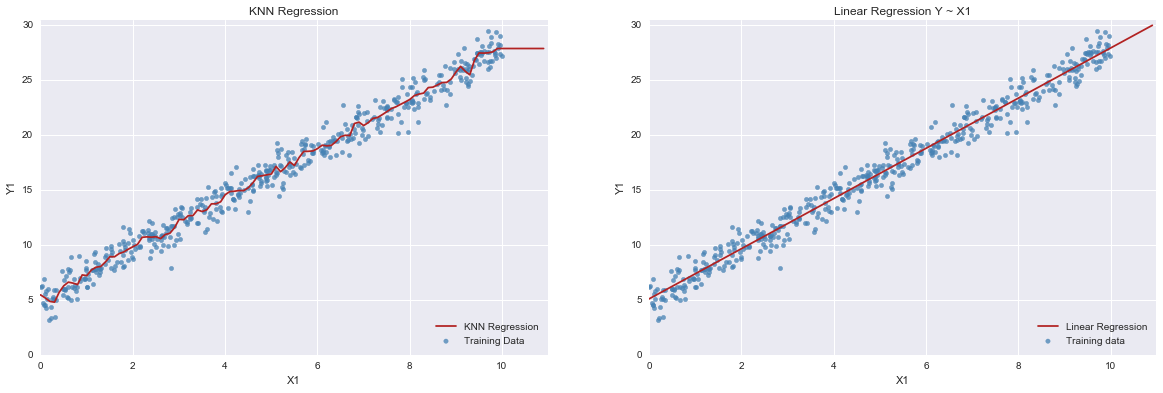

In [8]:
# [3] 
def p2_q1a_data(e=1):
    # Get data
    X1 = np.random.uniform(low=0, high=10, size=500)
    es = np.random.normal(loc=0, scale=e, size=500)
    Y = [5 + (2.3 * x) + e for x,e in zip(X1, es)]
    return pd.DataFrame.from_records(data=zip(Y,X1), columns=['Y','X1'])

# Get data
data = p2_q1a_data()

# Fit the KNN Regressor
clf = neighbors.KNeighborsRegressor(n_neighbors=11)
clf.fit(data[['X1']], data.Y)

# Predictions for Y
test_X1 = np.arange(np.min(data.X1) - 1, np.max(data.X1) + 1, .1)
tdf = pd.DataFrame.from_records(data=zip(test_X1), columns=['X1'])
Y_hat = clf.predict(tdf[['X1']])

# Plot the KNN regression
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,2,1)
axes.scatter(data.X1, data.Y, color='steelblue', alpha=0.75, label = 'Training Data')
axes.plot(tdf.X1, Y_hat, color='firebrick', label="KNN Regression")


axes.legend(loc='lower right')
axes.set_title("KNN Regression")
axes.set_xlim(0, np.max(data.X1) + 1)
axes.set_ylim(0, np.max(data.Y) + 1)
axes.set_xlabel("X1")
axes.set_ylabel("Y1")


# Run a Linear Regression for comparison
y, X = patsy.dmatrices('Y ~ X1', data)
model = linear.LinearRegression(fit_intercept=False).fit(X,y)

tdf['Y'] = 0
y, X = patsy.dmatrices('Y ~ X1', tdf)
Y_hat = model.predict(X)

axes = figure.add_subplot(1,2,2)
axes.scatter(data.X1, data.Y, color='steelblue', alpha=0.75, label='Training data')
axes.plot(tdf.X1, Y_hat, color='firebrick', label='Linear Regression')

axes.legend(loc='lower right')
axes.set_title("Linear Regression Y ~ X1")
axes.set_xlim(0, np.max(data.X1) + 1)
axes.set_ylim(0, np.max(data.Y) + 1)
axes.set_xlabel("X1")
axes.set_ylabel("Y1")

plt.show()

**Observations**:
Using a simple linear relationship in the data, we can see an obvious difference between how KNN Regression and Linear Regression function.  The Linear Regression produces a straight line as it is modeling the data as a linear function $Y \sim X1$. KNN Regression produces a regression line that is much more fluid, reacting to the noise $\epsilon$ in the data, which re-emphasizes that KNN Regression is *non-linear*.

It is interesting to observe how adjusting $k$ changes the regression line as it increasing considers, or ignores the noise $\epsilon$ in the data:

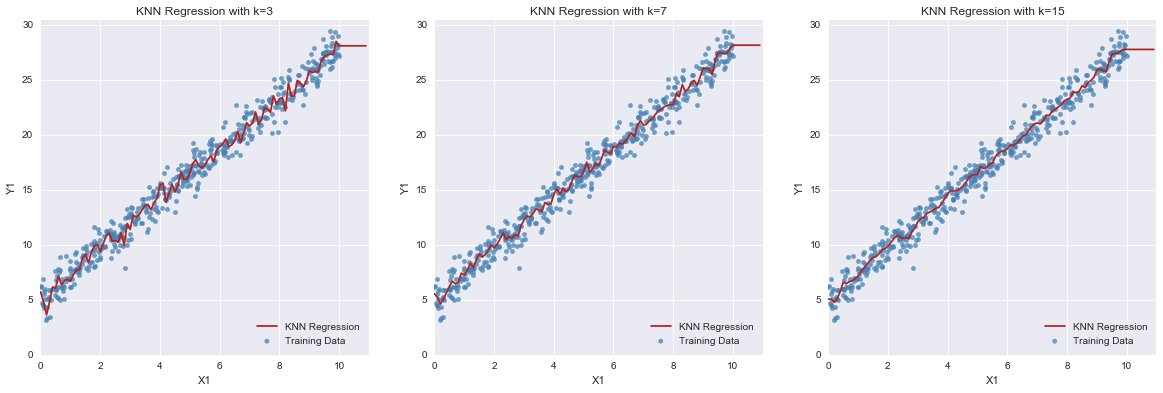

In [10]:
def KNN_regression_plots(data, ks=[3,7,15]):
    
    figure = plt.figure(figsize=(20,6))
    
    plots = xrange(1,len(ks)+1)
    for k,p in zip(ks,plots):
        # Fit KNN
        clf = neighbors.KNeighborsRegressor(n_neighbors=k)
        clf.fit(data[['X1']], data.Y)

        # Predictions for Y
        test_X1 = np.arange(np.min(data.X1) - 1, np.max(data.X1) + 1, .1)
        tdf = pd.DataFrame.from_records(data=zip(test_X1), columns=['X1'])
        Y_hat = clf.predict(tdf[['X1']])

        # Plot the KNN regression
        axes = figure.add_subplot(1,3,p)
        axes.scatter(data.X1, data.Y, color='steelblue', alpha=0.75, label = 'Training Data')
        axes.plot(tdf.X1, Y_hat, color='firebrick', label="KNN Regression")

        axes.legend(loc='lower right')
        axes.set_title("KNN Regression with k={0}".format(k))
        axes.set_xlim(0, np.max(data.X1) + 1)
        axes.set_ylim(0, np.max(data.Y) + 1)
        axes.set_xlabel("X1")
        axes.set_ylabel("Y1")

        
KNN_regression_plots(data=data)

**Observations**:
By increasing $k$ the KNN regression becomes less susceptible to the noise $\epsilon$ in the linear relationship. With $k=3$ the regression is much more sensitive to the noise, producing a jagged line.  Moving all the way to $k=13$ produces a much smoother regression & line. 



**P2 Q1a**: _What if the function is very non-linear?_

For our non-linear example, lets consider what happens when we have the relationship $Y = 5 + 2(X_1^2) + \epsilon$, where:
- $X_1$ is *uniformly* randomly distributed from (0,5)
- $\epsilon = N(0,1)$

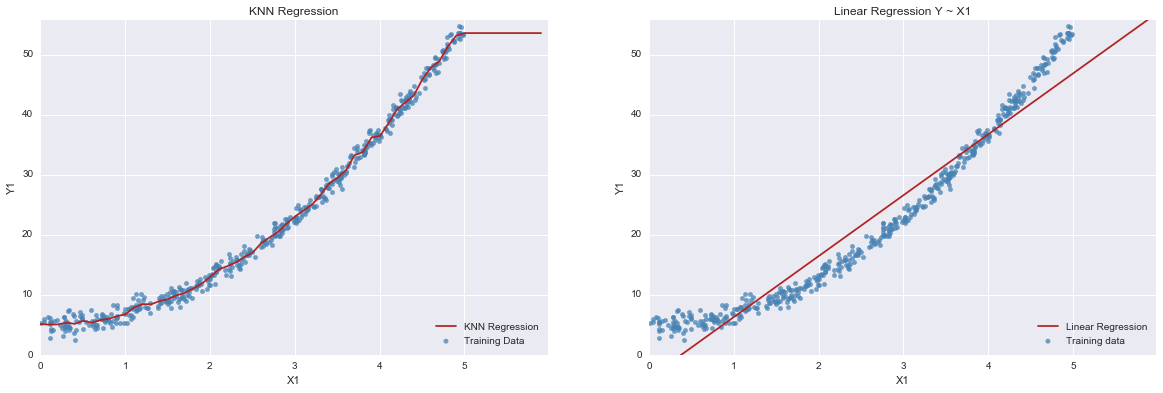

In [13]:
def p2_q1a_data(e=1):
    set_seed()

    X1 = np.random.uniform(low=0, high=5, size=500)
    es = np.random.normal(loc=0, scale=e, size=500)
    Y = [5 + (2 * x**2) + e for x,e in zip(X1,es)]
    return pd.DataFrame.from_records(data=zip(Y,X1), columns=['Y','X1'])
    
data = p2_q1a_data()

# Fit the KNN Regressor
clf = neighbors.KNeighborsRegressor(n_neighbors=11)
clf.fit(data[['X1']], data.Y)

# Predictions for Y
test_X1 = np.arange(np.min(data.X1) - 1, np.max(data.X1) + 1, .1)
tdf = pd.DataFrame.from_records(data=zip(test_X1), columns=['X1'])
Y_hat = clf.predict(tdf[['X1']])

# Plot the KNN regression
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,2,1)
axes.scatter(data.X1, data.Y, color='steelblue', alpha=0.75, label = 'Training Data')
axes.plot(tdf.X1, Y_hat, color='firebrick', label="KNN Regression")

axes.legend(loc='lower right')
axes.set_title("KNN Regression")
axes.set_xlim(0, np.max(data.X1) + 1)
axes.set_ylim(0, np.max(data.Y) + 1)
axes.set_xlabel("X1")
axes.set_ylabel("Y1")


# Run a Linear Regression for comparison
y, X = patsy.dmatrices('Y ~ X1', data)
model = linear.LinearRegression(fit_intercept=False).fit(X,y)

tdf['Y'] = 0
tdf.describe()
y, X = patsy.dmatrices('Y ~ X1', tdf)
Y_hat = model.predict(X)

axes = figure.add_subplot(1,2,2)
axes.scatter(data.X1, data.Y, color='steelblue', alpha=0.75, label='Training data')
axes.plot(tdf.X1, Y_hat, color='firebrick', label='Linear Regression')

axes.legend(loc='lower right')
axes.set_title("Linear Regression Y ~ X1")
axes.set_xlim(0, np.max(data.X1) + 1)
axes.set_ylim(0, np.max(data.Y) + 1)
axes.set_xlabel("X1")
axes.set_ylabel("Y1")
plt.show()

**Observations**:

KNN Regression clearly does a much better job of prediction in the event of a non-linear relationship at the start.  The predictions from the regression very closely follow the training data, while in Linear Regression we would have to manipulate the variables directly, specifically converting $X_1 => X_1^2$ in this experiment.

**P2 Q2**:_What if the data is very disperse? (try different  $\epsilon$ )._

Lets go back to our original example but try iteratively increasing $\epsilon$:

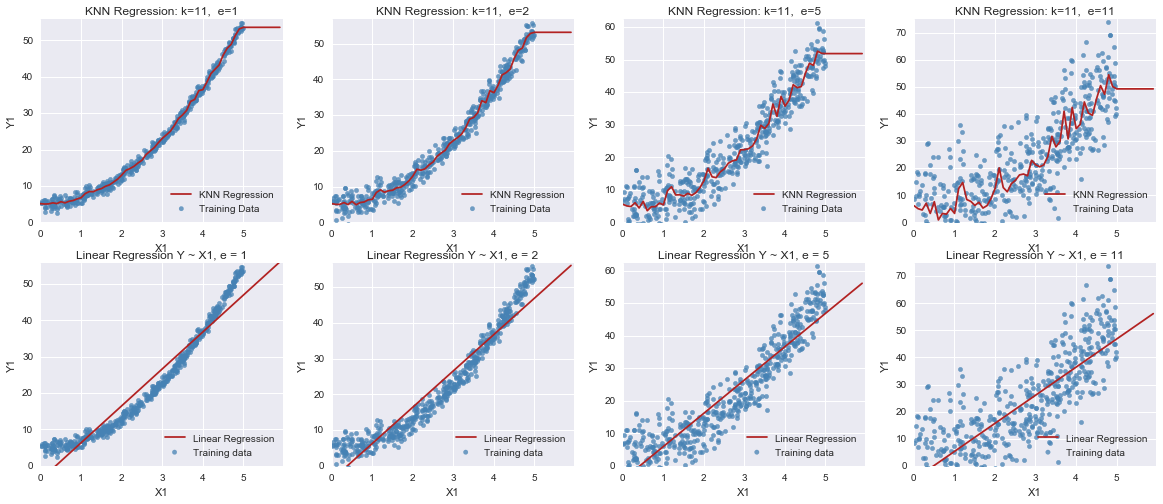

In [14]:
def plot_KNN_vs_LM(es=[1,2,5,11], k=11):
    
    figure = plt.figure(figsize=(20,8))
    
    ps = xrange(1, len(es)+1)
    for e,p in zip(es,ps):
    
        data = p2_q1a_data(e=e)
    
        # Fit the KNN Regressor
        clf = neighbors.KNeighborsRegressor(n_neighbors=11)
        clf.fit(data[['X1']], data.Y)

        # Predictions for Y
        test_X1 = np.arange(np.min(data.X1) - 1, np.max(data.X1) + 1, .1)
        tdf = pd.DataFrame.from_records(data=zip(test_X1), columns=['X1'])
        Y_hat = clf.predict(tdf[['X1']])

        # Plot the KNN regression
        axes = figure.add_subplot(2,len(ps),p)
        axes.scatter(data.X1, data.Y, color='steelblue', alpha=0.75, label = 'Training Data')
        axes.plot(tdf.X1, Y_hat, color='firebrick', label="KNN Regression")
        axes.legend(loc='lower right')
        axes.set_title("KNN Regression: k={0},  e={1}".format(k, e))
        axes.set_xlim(0, np.max(data.X1) + 1)
        axes.set_ylim(0, np.max(data.Y) + 1)
        axes.set_xlabel("X1")
        axes.set_ylabel("Y1")
        
        # Run a Linear Regression for comparison
        y, X = patsy.dmatrices('Y ~ X1', data)
        model = linear.LinearRegression(fit_intercept=False).fit(X,y)

        tdf['Y'] = 0
        tdf.describe()
        y, X = patsy.dmatrices('Y ~ X1', tdf)
        Y_hat = model.predict(X)

        axes = figure.add_subplot(2,len(ps),p + len(ps))
        axes.scatter(data.X1, data.Y, color='steelblue', alpha=0.75, label='Training data')
        axes.plot(tdf.X1, Y_hat, color='firebrick', label='Linear Regression')

        axes.legend(loc='lower right')
        axes.set_title("Linear Regression Y ~ X1, e = {0}".format(e))
        axes.set_xlim(0, np.max(data.X1) + 1)
        axes.set_ylim(0, np.max(data.Y) + 1)
        axes.set_xlabel("X1")
        axes.set_ylabel("Y1")
        
        

plot_KNN_vs_LM()

**Observations**:
The impact of increasing $\epsilon$ is abundantly obvious on KNN Regression.  We can see that the regression is very sensitive to the presence of noise, becoming much more jagged and fuzzy as $\epsilon$ increases.  This makes sense as KNN isn't trying to force-fit a linear model that explains the data, but is rather using the data itself to _predict_ the variable we're interested in $Y$, and thus noise will influence that prediction.  The Linear Regression is much less susceptible to noise.  Some interesting conclusions we can draw from this are:

- KNN may be comparitively better for _prediction_ than Linear Regression, as its leveraging the entirety of the training data. 
- Linear Regression may have stronger _explanatory_ power, as it can help us determine if the variable's we've intentionally included in the model ($X_i$) are actually contributing to the value of the variable ($Y$) we're interested in, and to what degree. 



**P2 Q3**: _Other than mean centering or some other normalization, do we need transformations of the  $X_i$ variables for kNN regression?_

**Answer**:

**No**.  KNN Regression uses the data _as-is_ to predict the variable $Y$ that we're interested in. Unlike Linear Regression, it is _not_ trying to derive a linear relationship from the data $Y \sim \beta_0 + \beta_1X_1$, which is why transformations are necessary when modeling non-linear relationships with Linear Regression. 

Consider this example where $Y = 5 + 2(X_1^2) + \epsilon$:
- $X_1$ is uniformly randomly distributed from (0,5)
- $\epsilon = N(0,1)$

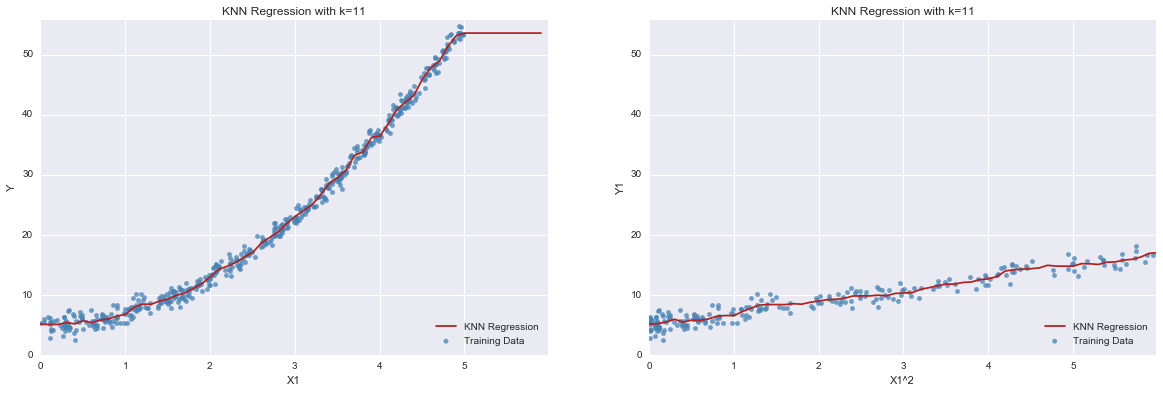

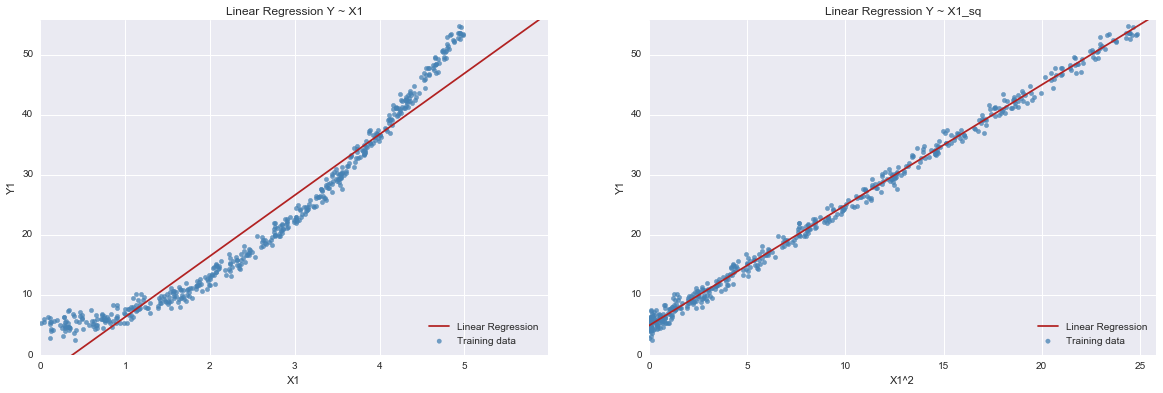

In [15]:
def p2_q3_data():
    set_seed()
    X1 = np.random.uniform(low=0, high=5, size=500)
    es = np.random.normal(loc=0, scale=1, size=500)
    Y = [5 + (2 * x**2) + e for x,e in zip(X1,es)]
    return pd.DataFrame.from_records(data=zip(Y,X1), columns=['Y','X1'])


def plot_KNN_transformed(data, k=11):
    # Fit the KNN Regressor
    clf = neighbors.KNeighborsRegressor(n_neighbors=k)
    clf.fit(data[['X1']], data.Y)

    # Predictions for Y
    test_X1 = np.arange(np.min(data.X1) - 1, np.max(data.X1) + 1, .1)
    tdf = pd.DataFrame.from_records(data=zip(test_X1), columns=['X1'])
    Y_hat = clf.predict(tdf[['X1']])
    
    # Plot the KNN Regression
    figure = plt.figure(figsize=(20,6))
    axes = figure.add_subplot(1,2,1)
    axes.scatter(data.X1, data.Y, color='steelblue', alpha=0.75, label = 'Training Data')
    axes.plot(tdf.X1, Y_hat, color='firebrick', label="KNN Regression")
    axes.legend(loc='lower right')
    axes.set_title("KNN Regression with k={0}".format(k))
    axes.set_xlim(0, np.max(data.X1) + 1)
    axes.set_ylim(0, np.max(data.Y) + 1)
    axes.set_xlabel('X1')
    axes.set_ylabel('Y')
    
    # Fit KNN Regressor using a transformation of X1
    data['X1_sq'] = np.square(data['X1'])
    clf = neighbors.KNeighborsRegressor(n_neighbors=k)
    clf.fit(data[['X1_sq']], data.Y)
    
    # Predictions for Y
    test_X1_sq = np.arange(np.min(data.X1_sq) - 1, np.max(data.X1_sq) + 1, .1)
    tdf = pd.DataFrame.from_records(data=zip(test_X1_sq), columns=['X1_sq'])
    Y_hat = clf.predict(tdf[['X1_sq']])
    
    # Plot KNN Regression on transformed variable
    axes = figure.add_subplot(1,2,2)
    axes.scatter(data.X1_sq, data.Y, color='steelblue', alpha=0.75, label = 'Training Data')
    axes.plot(tdf.X1_sq, Y_hat, color='firebrick', label="KNN Regression")
    axes.legend(loc='lower right')
    axes.set_title("KNN Regression with k={0}".format(k))
    axes.set_xlim(0, np.max(data.X1) + 1)
    axes.set_ylim(0, np.max(data.Y) + 1)
    axes.set_xlabel("X1^2")
    axes.set_ylabel("Y1")
    plt.show()

    
def plot_lm_transformed(data):
    # Run a Linear Regression for comparison
    y, X = patsy.dmatrices('Y ~ X1', data)
    model = linear.LinearRegression(fit_intercept=False).fit(X,y)

    # Predict
    test_X1 = np.arange(np.min(data.X1) - 1, np.max(data.X1) + 1, .1)
    tdf = pd.DataFrame.from_records(data=zip(test_X1), columns=['X1'])
    tdf['Y'] = 0
    y, X = patsy.dmatrices('Y ~ X1', tdf)
    Y_hat = model.predict(X)

    # Plot
    figure = plt.figure(figsize=(20,6))
    axes = figure.add_subplot(1,2,1)
    axes.scatter(data.X1, data.Y, color='steelblue', alpha=0.75, label='Training data')
    axes.plot(tdf.X1, Y_hat, color='firebrick', label='Linear Regression')
    axes.legend(loc='lower right')
    axes.set_title("Linear Regression Y ~ X1")
    axes.set_xlim(0, np.max(data.X1) + 1)
    axes.set_ylim(0, np.max(data.Y) + 1)
    axes.set_xlabel("X1")
    axes.set_ylabel("Y1")
    
    # LM using transformed X1
    formula = 'Y ~ X1_sq'
    data['X1_sq'] = np.square(data.X1)
    y,X = patsy.dmatrices(formula, data)
    model = linear.LinearRegression(fit_intercept=False).fit(X,y)
    
    # Predict
    test_X1_sq = np.arange(np.min(data.X1_sq) -1, np.max(data.X1_sq) + 1, .1)
    tdf = pd.DataFrame.from_records(data=zip(test_X1_sq), columns=['X1_sq'])
    tdf['Y'] = 0
    y, X = patsy.dmatrices(formula, tdf)
    Y_hat = model.predict(X)
    
    # Plot it
    axes = figure.add_subplot(1,2,2)
    axes.scatter(data.X1_sq, data.Y, color='steelblue', alpha=0.75, label='Training data')
    axes.plot(tdf.X1_sq, Y_hat, color='firebrick', label='Linear Regression')
    axes.legend(loc='lower right')
    axes.set_title("Linear Regression {0}".format(formula))
    axes.set_xlim(0, np.max(data.X1_sq) + 1)
    axes.set_ylim(0, np.max(data.Y) + 1)
    axes.set_xlabel("X1^2")
    axes.set_ylabel("Y1")
    plt.show()


data = p2_q3_data()
plot_KNN_transformed(data=data)
plot_lm_transformed(data=data)

**Observations**:

Transforming $X_1$ to $X_1^2$ simply results in the KNN Regressor using $X_1^2$ for its predictions, having no bearing the accuracy of those predictions.  However, with Linear Regression we see the importance that transformations of variables can have in achieving a better fitting model, as shown by the plot on the right.  Transformation is an important technique in Linear (and Logistic) Regression as it creates a variable that fits within the techniques those approaches employ.

----

** Problem 3. Clustering **

Use k-Means Clustering on clustering problems of your own creation. You should explore the following points: 

1. What if the data has no clusters (there are no hidden categorical variables)?
2. Now assume that you have some "hidden" categorical variable and the clusters are compact and distinct as well as having the same variance? What does the Elbow Method show for the k you should use?
3. Now assume that you have some "hidden" categorical variable and the clusters are disperse? Different variances? What does the Elbow Method show for the k you should use?

**P3 Q1**: _What if the data has no clusters (there are no hidden categorical variables)?_

We'll use a simple data set of uniformly, randomly distributed variables $X_1$, $X_2$ over the interval (0,10).

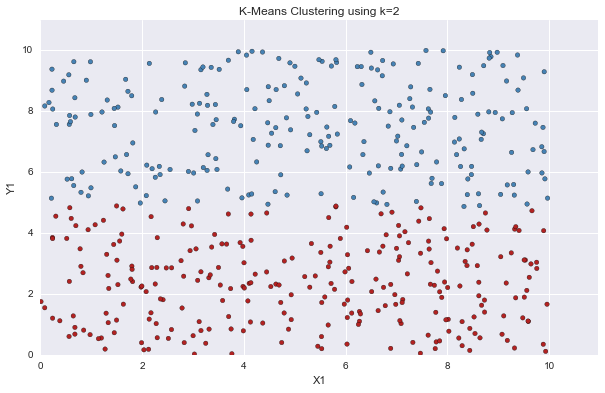

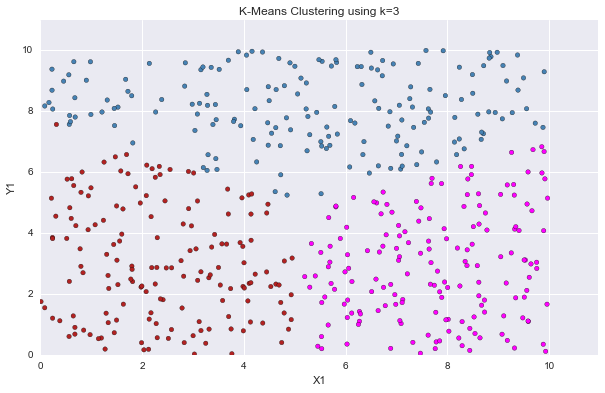

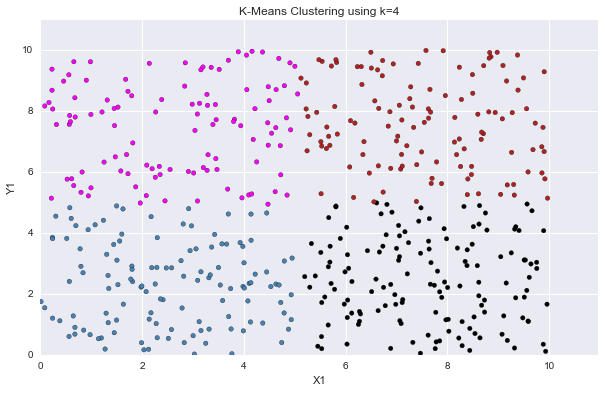

In [16]:
def p3_q1_data():
    set_seed()
    X1 = np.random.uniform(low=0, high=10, size=500)
    X2 = np.random.uniform(low=0, high=10, size=500)
    return pd.DataFrame.from_records(data=zip(X1,X2), columns=['X1','X2'])

def KMeans_cluster(data, k):
    results = {}
    
    # Initialize & predict clusters
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kcl = kmeans.fit(data)
    
    results['data'] = data
    results['k'] = k
    results['labels'] = kcl.labels_
    results['centers'] = kcl.cluster_centers_
    
    # Calculate the SSE (Sum of Squared Errors)
    errors = []
    for label, x1, x2 in zip(kcl.labels_, data.X1, data.X2):
        center = kcl.cluster_centers_[label]
        dist = pairwise.euclidean_distances([[x1,x2]],[center])[0][0]
        errors.append(dist**2)
    results['SSE'] = np.sum(errors)

    return results

# Given a dataframe with X1, X2 & Label, plot it
def plot_KMeans_Clustering(results, colors=[]):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)
    
    data = results['data']
    axes.scatter(data.X1, data.X2, c=results['labels'], cmap=ListedColormap(colors))
    axes.set_title('K-Means Clustering using k={0}'.format(results['k']))
    axes.set_xlim(0, np.max(data.X1) + 1)
    axes.set_ylim(0, np.max(data.X2) + 1)
    axes.set_xlabel('X1')
    axes.set_ylabel('Y1')
    plt.show()

# Get Data
data = p3_q1_data()

# K=2
results = KMeans_cluster(data=data, k=2)
plot_KMeans_Clustering(results, colors=['steelblue','firebrick'])

# K = 3
results = KMeans_cluster(data=data, k=3)
plot_KMeans_Clustering(results, colors=['steelblue','firebrick','magenta'])

# k = 4
results = KMeans_cluster(data=data, k=4)
plot_KMeans_Clustering(results, colors=['steelblue','firebrick','magenta','black'])

**Observations**:

Absent any underlying clustering in the data,  K-Means Clustering simply attempts to evenly partition the datapoints based on K, presumbably because of how it evenly (or 'randomly') determines the centroids to begin with. When K is even, we do see relatively even distribution of points to each resulting classification label. When K is odd, its a little more obvious regarding the approach this K-Means Clustering implementation is taking when partitioning the data. 

**P3 Q2**: _Now assume that you have some "hidden" categorical variable and the clusters are compact and distinct as well as having the same variance? What does the Elbow Method show for the k you should use?_

Lets make this more interesting by using a categorical variable having 5 possible values C=(1,5):
- when C=1,  $X_1$ and $X_2$ are $N(1, \sigma=.5)$
- when C=2,  $X_1$ and $X_2$ are $N(3, \sigma=.5)$
- when C=3,  $X_1$ and $X_2$ are $N(6, \sigma=.5)$
- when C=4,  $X_1 = N(8, \sigma=.5)$, $X_2 = N(5, \sigma=.5)$
- when C=5,  $X_1 = N(8, \sigma=.5)$, $X_2 = N(2, \sigma=.5)$

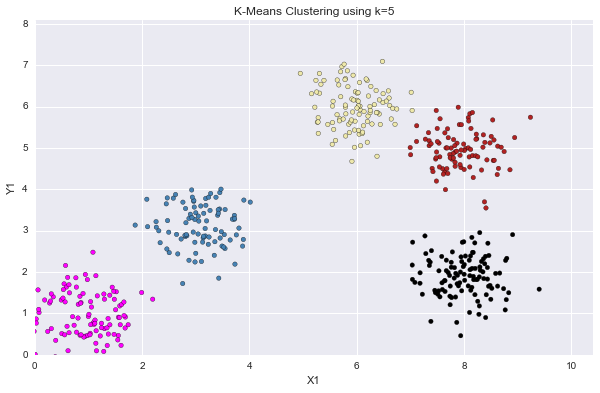

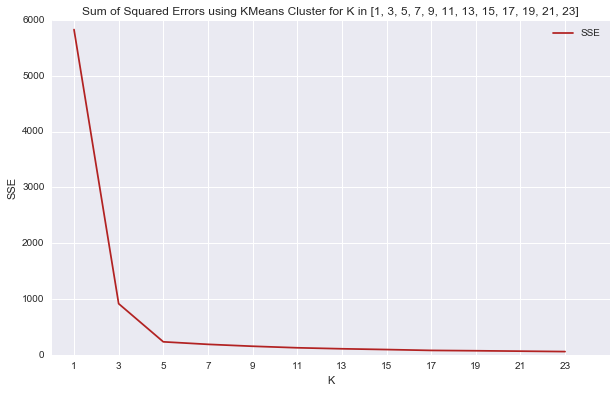

,K,SSE,95% CI(low),95% CI(high),CI range
0,1,5828.532825,5540.876653,6038.968844,498.092191
1,3,915.941826,867.068534,973.883620,106.815086
2,5,232.572360,219.275205,242.874427,23.599223
3,7,187.510666,172.945901,204.188102,31.242201
4,9,153.230332,148.989704,162.724207,13.734503
5,11,125.799411,112.651150,137.370128,24.718979
6,13,107.778598,103.486300,114.025598,10.539298
7,15,94.049799,83.766387,102.206005,18.439618
8,17,78.624865,72.145518,83.640125,11.494607
9,19,72.601429,67.183661,78.587011,11.403349


In [17]:
def p3_q2_data():
    set_seed()
    cs = np.random.randint(low=1, high=6, size=500)
    
    X1 = []
    X2 = []
    for c in cs:
        if c == 1:
            X1.append(np.random.normal(1,.5))
            X2.append(np.random.normal(1,.5))
        if c == 2:
            X1.append(np.random.normal(3,.5))
            X2.append(np.random.normal(3,.5))
        if c == 3:
            X1.append(np.random.normal(6,.5))
            X2.append(np.random.normal(6,.5))
        if c == 4:
            X1.append(np.random.normal(8,.5))
            X2.append(np.random.normal(5,.5))
        if c == 5:
            X1.append(np.random.normal(8,.5))
            X2.append(np.random.normal(2,.5))
            
    return pd.DataFrame.from_records(data=zip(X1,X2), columns=['X1','X2'])


# Run KMeans Clustering using a variety of K
data = p3_q2_data()


colors=['steelblue','firebrick','magenta','black', 'palegoldenrod']
ks = [1,3,5,7,9,11,13,15,17,19,21,23]
sses = []

# Iterate through our samples of K and bootstrap the SSE
for k in ks:
    
    # Bootstrap each k
    boot_sses = []
    for _ in xrange(10):
        n = len(data)
        indices = [py_random.randint(0,n-1) for _ in xrange(0,n)]
        resampled = data.iloc[indices]
        result = KMeans_cluster(data=resampled, k=k)
        boot_sses.append(result['SSE'])
        
    # gather results
    low, high = stats.mstats.mquantiles(boot_sses, [0.025, 0.975])
    results = KMeans_cluster(data=data, k=k)
    sses.append((k,np.mean(boot_sses), low, high))
    if (k==5):
        plot_KMeans_Clustering(results, colors=colors)
 
# Makes the results a little easier to work with
results = pd.DataFrame.from_records(data=sses, columns=['K','SSE','95% CI(low)','95% CI(high)'])
results['CI range'] = results['95% CI(high)'] - results['95% CI(low)']

# Plot the Sum of Squared Errors for K
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1,1,1)
axes.plot(results.K, results.SSE, color='firebrick', label='SSE')
axes.set_title("Sum of Squared Errors using KMeans Cluster for K in {0}".format(ks))
axes.set_xticks(ks)
axes.set_xticklabels(ks)
axes.set_xlabel("K")
axes.set_ylabel("SSE")
axes.legend()
plt.show()
display(results)

**Observations**:
The _Elbow Method_ makes it very clear that $K=5$ would be the best $K$ to use, as there is a distinct bend (elbow) in the graph that stops at 5, after which the SSE shows minimal improvement for each additional $K$.  This is a strong indicator that there are 5 clusters in the data.


**P3 Q3**: _Now assume that you have some "hidden" categorical variable and the clusters are disperse? Different variances? What does the Elbow Method show for the k you should use?_


We'll use the original data from the 2nd question, but increase the variance signficantly in some of the clusters to create some overlap:
- when C=1,  $X_1$ and $X_2$ are $N(1, \sigma=2)$
- when C=2,  $X_1$ and $X_2$ are $N(3, \sigma=2)$
- when C=3,  $X_1$ and $X_2$ are $N(6, \sigma=.5)$
- when C=4,  $X_1 = N(8, \sigma=.5)$, $X_2 = N(5, \sigma=3)$
- when C=5,  $X_1 = N(8, \sigma=.5)$, $X_2 = N(2, \sigma=3)$

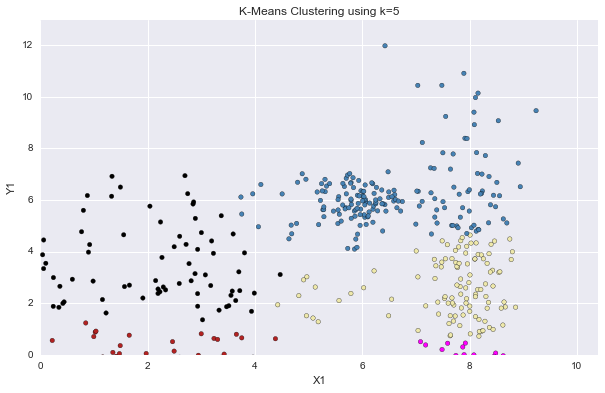

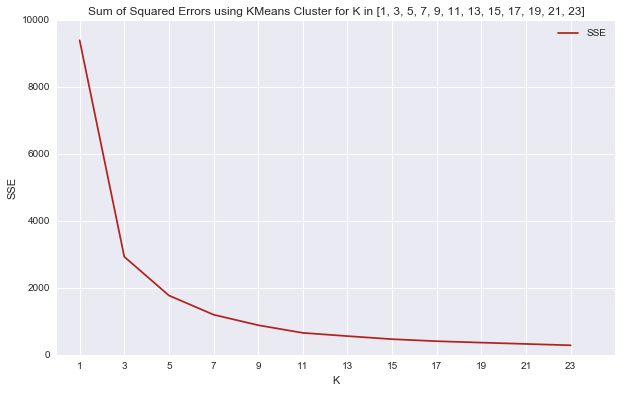

,K,SSE,95% CI(low),95% CI(high),CI range
0,1,9393.347917,8944.247457,9848.941966,904.694509
1,3,2928.624049,2618.258710,3113.796533,495.537823
2,5,1771.418180,1595.579191,1969.507927,373.928736
3,7,1198.033501,1077.477508,1310.295448,232.817940
4,9,883.804080,792.074426,995.877243,203.802817
5,11,654.776097,598.738473,707.604337,108.865864
6,13,558.457023,495.634618,618.857807,123.223188
7,15,466.899820,437.850034,501.618872,63.768838
8,17,406.301940,380.114723,435.704452,55.589729
9,19,364.160367,339.798702,382.269629,42.470927


In [18]:
def p3_q3_data():
    set_seed()
    cs = np.random.randint(low=1, high=6, size=500)
    
    X1 = []
    X2 = []
    for c in cs:
        if c == 1:
            X1.append(np.random.normal(1,2))
            X2.append(np.random.normal(1,2))
        if c == 2:
            X1.append(np.random.normal(3,2))
            X2.append(np.random.normal(3,2))
        if c == 3:
            X1.append(np.random.normal(6,.5))
            X2.append(np.random.normal(6,.5))
        if c == 4:
            X1.append(np.random.normal(8,.5))
            X2.append(np.random.normal(5,3))
        if c == 5:
            X1.append(np.random.normal(8,.5))
            X2.append(np.random.normal(2,3))
            
    return pd.DataFrame.from_records(data=zip(X1,X2), columns=['X1','X2'])

data = p3_q3_data()

colors=['steelblue','firebrick','magenta','black', 'palegoldenrod']
ks = [1,3,5,7,9,11,13,15,17,19,21,23]
sses = []

# Iterate through our samples of K and bootstrap the SSE
for k in ks:
    
    # Bootstrap each k
    boot_sses = []
    for _ in xrange(10):
        n = len(data)
        indices = [py_random.randint(0,n-1) for _ in xrange(0,n)]
        resampled = data.iloc[indices]
        result = KMeans_cluster(data=resampled, k=k)
        boot_sses.append(result['SSE'])
        
    # gather results
    low, high = stats.mstats.mquantiles(boot_sses, [0.025, 0.975])
    results = KMeans_cluster(data=data, k=k)
    sses.append((k,np.mean(boot_sses), low, high))
    if (k==5):
        plot_KMeans_Clustering(results, colors=colors)
 
# Makes the results a little easier to work with
results = pd.DataFrame.from_records(data=sses, columns=['K','SSE','95% CI(low)','95% CI(high)'])
results['CI range'] = results['95% CI(high)'] - results['95% CI(low)']

# Plot the Sum of Squared Errors for K
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1,1,1)
axes.plot(results.K, results.SSE, color='firebrick', label='SSE')
axes.set_title("Sum of Squared Errors using KMeans Cluster for K in {0}".format(ks))
axes.set_xticks(ks)
axes.set_xticklabels(ks)
axes.set_xlabel("K")
axes.set_ylabel("SSE")
axes.legend()
plt.show()
display(results)

**Observations**:
There is no longer a _clear_ elbow in the SSE graph as there was with the more distinct, low variance clusters generated for question 2.  There is a slight inflection at $K=3$, which does correspond with how the first 2 clusters (C1, C2) and last 2 clusters (C4,C5) had their data modified to increase the amount of overlap, causing them to bleed into one another. However, the improvement after $K=3$ follows a much more gradual curve, making it difficult to find a _good_ $K$.

----

**References**:

- [1] Module 9 - Model Evaluation
- [2] Nearest Neighbors Classification (Scikit-Learn): http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
- [3] KNN Regression: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html